# Интеллектуальный анализ данных – весна 2024

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [4]:
import math
k1=-0.8*math.log(0.8)
k2=-0.2*math.log(0.2)
print(round(k1+k2,2))

0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:
k1=0.8
k2=0.2
rk1=0
rk2=1
lk1=1
lk2=0
jl=1*(1-1)+0*(1-0)
jr=1*(1-1)+0*(1-0)
jm=0.8*(1-0.8)+0.2*(1-0.2)
inf=jm-(8/10)*jl-(2/10)*jr
print(inf)

0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
print(np.mean([1, 10, 5, 18, 100, 30, 50, 61, 84, 47]))

40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [2]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [102]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    def gini(y):
        a,u=np.unique(y,return_counts=True) #подсчет уник знач (частнотность)
        gini=1-np.sum((u/len(y))**2)
        return gini

    def var(y):
      mean=np.mean(y)
      d=(y-mean)**2  #квадраты отклонений
      meann=np.mean(d)
      return meann

    sortt=np.argsort(feature_vector) #индексы по возвр 
    f_s=feature_vector[sortt] #сам вектор, сорт по индексам
    t_s=target_vector[sortt] 
    thresholds=(f_s[:-1]+f_s[1:])/2 #В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    left=f_s[:,None]<=thresholds
    right=~left #маска, левые пороги 
    n_l=left.sum(axis=0) 
    n_r=right.sum(axis=0)
    #НИЖЕ 4 СТРОКИ, В КОТОРЫХ СОБРАНА ВСЯ БОЛЬ ЧЕЛОВЕЧЕСТВА
    #ВЫДАВАЛСЯ ПОРОГ 15.001, КОТОРЫЙ ПОГРУЗИЛ МЕНЯ В ОТЧАЯНИЕ 
    # ПЕРЕПИСЫВАЯ КОД С НУЛЯ (КАК С ЦИКЛАМИ, ТАК И БЕЗ В ТРЕТИЙ РАЗ), Я НЕ ОПУСТИЛА РУКИ И ДОГАДАЛАСЬ ПОСМОТРЕТЬ НА ГРАФИК 
    #итак
    check=(n_l>0)&(n_r>0) #проверяю, что пороги не будут делать одну ветвь пустой,а вторую - со всей выборкой
    tresholdss=thresholds[check] 
    nll=left[:,check]
    nrr=right[:,check]
    if tresholdss.size==0: 
        pass
    if task=='classification':
      i=gini
    elif task=='regression':
      i=var
    #дальше я руководствовалась теоретическим материалом по ссылке, чтобы сообразить, что к чему https://ashutoshtripathi.com/2022/03/29/a-complete-guide-to-decision-tree-formation-and-interpretation-in-machine-learning/
    leftt=np.apply_along_axis(lambda x:i(t_s[x]),0,nll)
    rightt=np.apply_along_axis(lambda x:i(t_s[x]),0,nrr)
    ginis=(n_l[check]/len(t_s))*leftt+(n_r[check]/len(t_s))*rightt
    best=np.argmin(ginis)
    threshold_best=tresholdss[best]
    gini_best=ginis[best]
    return tresholdss,ginis,threshold_best,gini_best

https://ashutoshtripathi.com/2022/03/29/a-complete-guide-to-decision-tree-formation-and-interpretation-in-machine-learning/


Эту функцию можно протестировать на датасете `California`.

In [87]:
from sklearn.datasets import fetch_california_housing

In [98]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [99]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [103]:
feature_vector=X['MedInc'].values
target_vector=y
thresholds,ginis,threshold_best,gini_best=find_best_split(feature_vector,target_vector,task='regression')

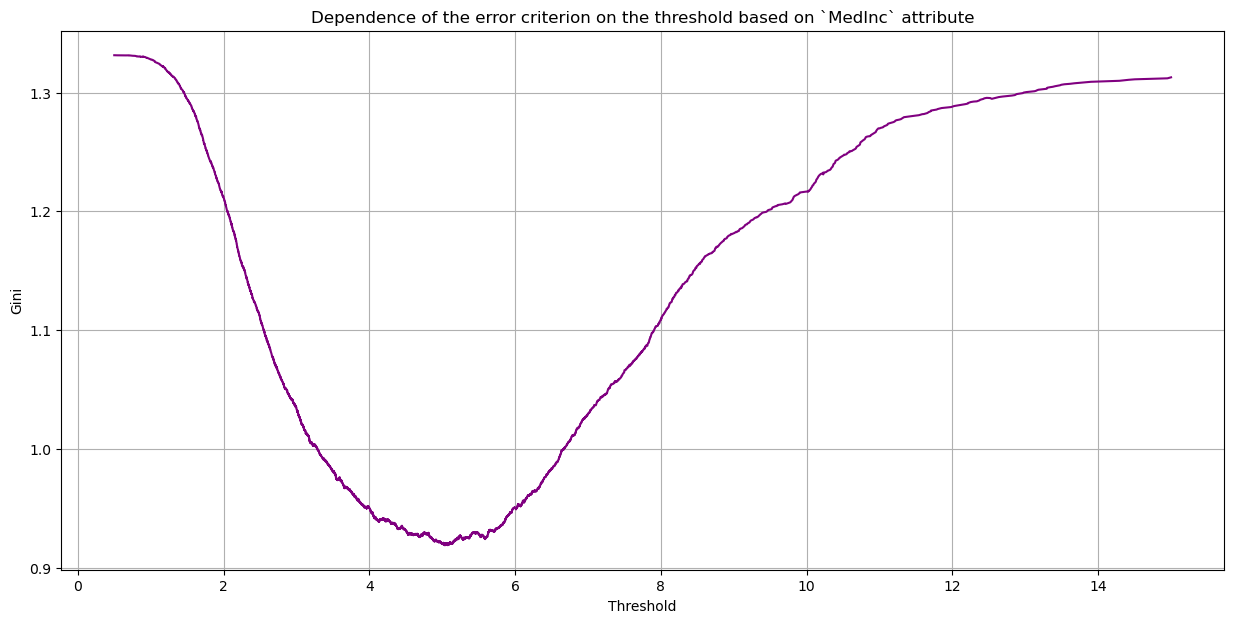

In [104]:
plt.figure(figsize=(15, 7))
plt.grid(True)
plt.plot(thresholds, ginis, color='purple')
plt.xlabel('Threshold')
plt.ylabel('Gini')
plt.title('Dependence of the error criterion on the threshold based on `MedInc` attribute')
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [105]:
print(threshold_best)

5.03515


# Ура! Это не 15.001, а значит все прекрасно. Получилось, что деление происходит ровно там, где график проседает. Я довольна.

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

# Код ниже  дальнейшей моей рефлексии ради. Вероятно, смысла смотреть его нет, так как на 2.4 выдает целый ворох разнообразных ошибок, которые фиксить не получилось 

In [76]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector<threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector==threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"]=="terminal":
            return node['class']
        split=node['feature_split']
        if  self._feature_types[split]=='real':
            if x[split]<node['threshold']:
                return  self._predict_node(x,node['left_child'])
            else:
                return self._predict_node(x,node['right_child'])
        elif self._feature_types[split]=='categorical':
            if x[split]==node['category_split']:
                return  self._predict_node(x,node['left_child'])
            else:
                return self._predict_node(x,node['right_child'])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

Text(0.5, 0, 'Threshold')

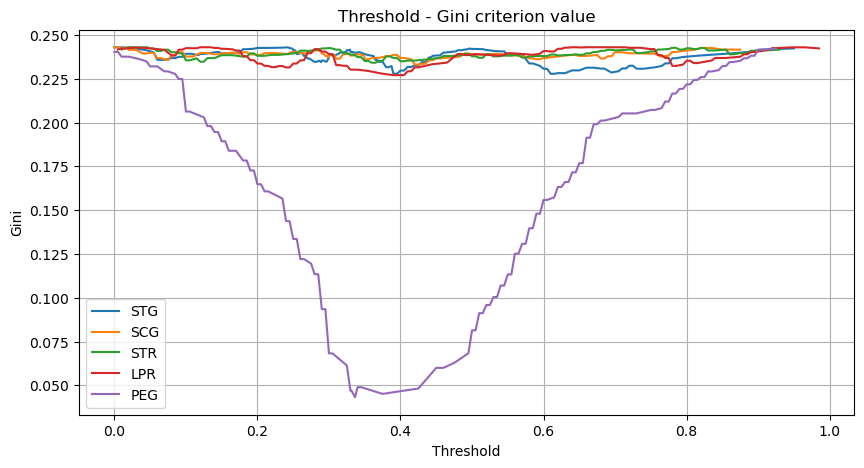

In [109]:
import matplotlib.pyplot as plt
students='https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/students.csv'
df=pd.read_csv(students)
X=df[:-1]
y=df['UNS']
feat=['STG','SCG','STR','LPR','PEG']
plt.figure(figsize=(10,5))
plt.grid(True)
for f in range(len(feat)):
    feature_vector=X[feat[f]].values
    target_vector=y
    thresholds,ginis,threshold_best,gini_best=find_best_split(feature_vector,target_vector,task='regression')
    plt.plot(thresholds,ginis,label=f)
plt.title('Threshold - Gini criterion value')
plt.legend(feat)
plt.ylabel('Gini')
plt.xlabel('Threshold')

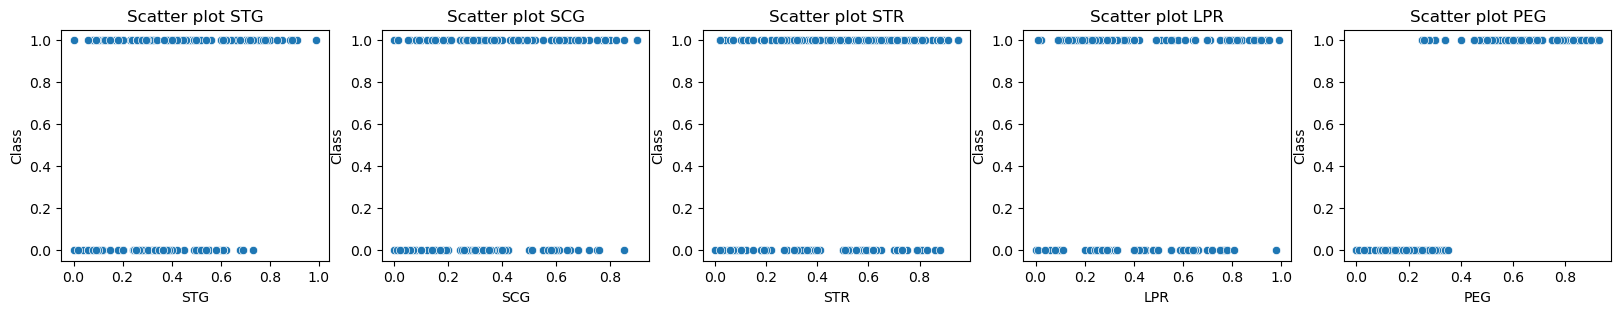

In [107]:
import seaborn as sns
f,ax=plt.subplots(1,5,figsize=(20, 3)) #ломался без f!!
for f in range(len(feat)):
    sns.scatterplot(x=X[feat[f]],y=y,ax=ax[f])#sns вместо plt из-за особенностей библиотеки plt и axes!!
    ax[f].set_xlabel(feat[f])
    ax[f].set_ylabel('Class')
    ax[f].set_title(f'Scatter plot {feat[f]}')
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

# Явно по PEG. На графике у него есть минимум, радикально отличный от остальных признаков. На диаграмме явно видно, что можно провести качественное деление на два поддерева 

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [77]:
#ИСПОЛЬЗУЮ СПОСОБ ИЗ ОБЩЕГО ЧАТА ТГ, КОТОРЫЙ ПОСОВЕТОВАЛ @tolkonachalo, ТАК КАК ПО ССЫЛКЕ ДАТАСЕТ НЕДОСТУПЕН!!!
!pip install ucimlrepo
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo 
mushroom = fetch_ucirepo(id=73) 
X = mushroom.data.features 
y = mushroom.data.targets
display(X)

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,s,o,o,p,o,o,p,b,c,l
8120,x,s,n,f,n,a,c,b,y,e,...,s,o,o,p,n,o,p,b,v,l
8121,f,s,n,f,n,a,c,b,n,e,...,s,o,o,p,o,o,p,b,c,l
8122,k,y,n,f,y,f,c,n,b,t,...,k,w,w,p,w,o,e,w,v,l


In [78]:
le=LabelEncoder()
y=le.fit_transform(y)
for x in X.columns:
    X[x]=le.fit_transform(X[x])
display(X)

C:\Users\79153\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\79153\AppData\Local\Temp\ipykernel_13440\285719699.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[x]=le.fit_transform(X[x])
C:\Users\79153\AppData\Local\Temp\ipykernel_13440\285719699.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,3,2,4,0,5,0,0,0,11,0,...,2,5,5,0,1,1,4,0,1,2
8120,5,2,4,0,5,0,0,0,11,0,...,2,5,5,0,0,1,4,0,4,2
8121,2,2,4,0,5,0,0,0,5,0,...,2,5,5,0,1,1,4,0,1,2
8122,3,3,4,0,8,1,0,1,0,1,...,1,7,7,0,2,1,0,7,4,2


In [79]:
#Решающее дерево оказалось грустным, комментировать я его не стала, раз тут выдается ошибка
#в надежде на чудо (и свое знание рекурсии), написала тест для самодельного дерева, результат прискорбный 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1310)
feature_types=['categorical']*X_train.shape[1]
derevo=DecisionTree(feature_types=feature_types)
derevo.fit(X_train.values,y_train)
pred=derevo.predict(X_test.values)
acc=accuracy_score(y_test,pred)
print(acc)

ValueError: Cannot apply_along_axis when any iteration dimensions are 0

In [110]:
#было принято позорное решение - использовать дерево встроенное, чтобы хотя бы дотронуться до прекрасного 
from sklearn.tree import DecisionTreeClassifier
derevo=DecisionTreeClassifier(random_state=1310)
derevo.fit(X_train,y_train)
pred=derevo.predict(X_test)
print(accuracy_score(y_test,pred))

1.0


### Вааау, у этого встроенного дерева  accuracy на высоте (в отличие от моего) 

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [117]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [111]:
data = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

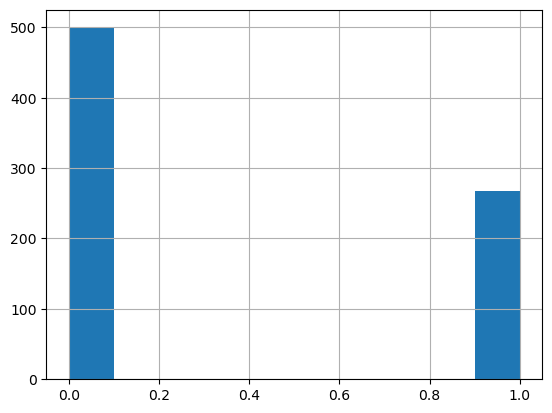

In [112]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [113]:
y=data['Outcome']
X=data.drop(columns=['Outcome'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1310)
X_train_tr, X_v, y_train_tr, y_v = train_test_split(X_train, y_train, test_size=0.3, random_state=1310)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [114]:
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
d=DecisionTreeClassifier(random_state=1310)
giper={'max_depth':[2,3,4,5,6,7,8,9,10],'min_samples_leaf':[2,3,4,5,6,7,8,9,10]}
best=GridSearchCV(d,giper,cv=3,scoring='f1') #использую лучшую вещь на планете - грид серч, чтобы подобрать самую хорошую комбинацию параметров
best.fit(X_train_tr,y_train_tr)
print(best.best_params_)

{'max_depth': 3, 'min_samples_leaf': 10}


In [115]:
f1=f1_score(y_v,best.best_estimator_.predict(X_v)) # ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.
print(f1)

0.5106382978723404


In [121]:
d=DecisionTreeClassifier(max_depth=3,min_samples_leaf=10,random_state=1310)
d.fit(X_train,y_train)
pred=d.predict(X_test)
pred_vero=d.predict_proba(X_test)[:, 1] #проверка вероятности принадлежности к классу 
print('Accuracy',accuracy_score(y_test,pred))
print('Precision',precision_score(y_test,pred))
print('Recall',recall_score(y_test,pred))
print('Roc Auc',roc_auc_score(y_test,pred_vero))

Accuracy 0.7229437229437229
Precision 0.7435897435897436
Recall 0.3493975903614458
Roc Auc 0.7977450341908172


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [122]:
cb=BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=1310)
cb.fit(X_train,y_train)
pred=cb.predict(X_test)
pred_vero=cb.predict_proba(X_test)[:, 1]
print('Accuracy',accuracy_score(y_test,pred))
print('Precision',precision_score(y_test,pred))
print('Recall',recall_score(y_test,pred))
print('Roc Auc',roc_auc_score(y_test,pred_vero))

Accuracy 0.7748917748917749
Precision 0.7627118644067796
Recall 0.5421686746987951
Roc Auc 0.81406707912732


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [125]:
rf=RandomForestClassifier(n_estimators=50,random_state=1310)
best=GridSearchCV(rf,giper,cv=3,scoring='f1')
best.fit(X_train,y_train)
print(best.best_params_)
print(best.best_score_)

{'max_depth': 8, 'min_samples_leaf': 3}
0.6457816546272318


In [126]:
rf.fit(X_train,y_train)
pred=rf.predict(X_test)
pred_vero=rf.predict_proba(X_test)[:, 1]
print('Accuracy',accuracy_score(y_test,pred))
print('Precision',precision_score(y_test,pred))
print('Recall',recall_score(y_test,pred))
print('Roc Auc',roc_auc_score(y_test,pred_vero))

Accuracy 0.7662337662337663
Precision 0.6933333333333334
Recall 0.6265060240963856
Roc Auc 0.834296646043634


## Последняя модель лучше, когда мы не хотим упускать положительные предсказания (если ложноотрицательные ответы для нас - плохи). Вторая модель меньше принимает отрицательные ответы за положительные (если цель - не принять отрицательное за положительное: например, когда делаем тест на болезнь, очень нежелательно квалифицировать небольного как больного, чтобы он не занимал попусту стационар), то можно выбрать вторую. Но так как рок аук выше у третьей, я склоняюсь больше к ней


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

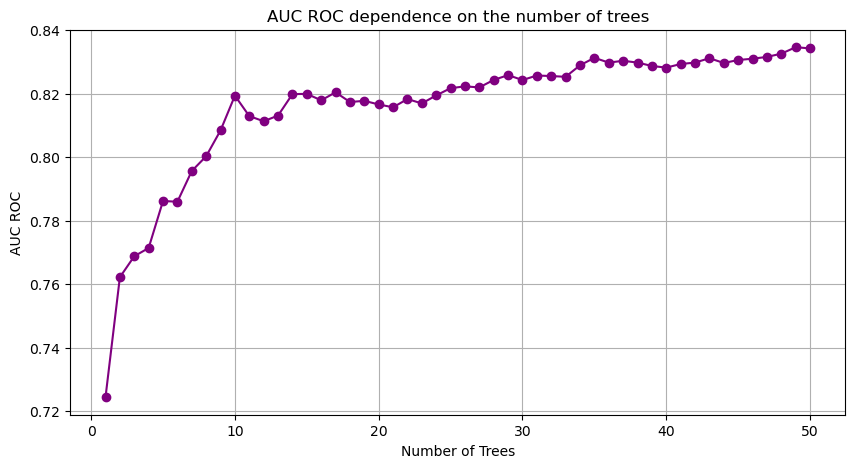

In [27]:
auc=[]
derevo=[i for i in range(1,51)]
k=0
for i in derevo:
    cb=RandomForestClassifier(n_estimators=i, random_state=1310)
    cb.fit(X_train,y_train)
    pred=cb.predict(X_test)
    pred_vero=cb.predict_proba(X_test)[:, 1]
    auc.append(roc_auc_score(y_test,pred_vero))
plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(derevo,auc,color='purple',marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('AUC ROC')
plt.title('AUC ROC dependence on the number of trees')
plt.show()

# С увеличением количества деревьев, качество модели улучшается. На 50 дереве начинается падение качества. Предполагаю, что дальше это будет ухудшаться (переобучение?)

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

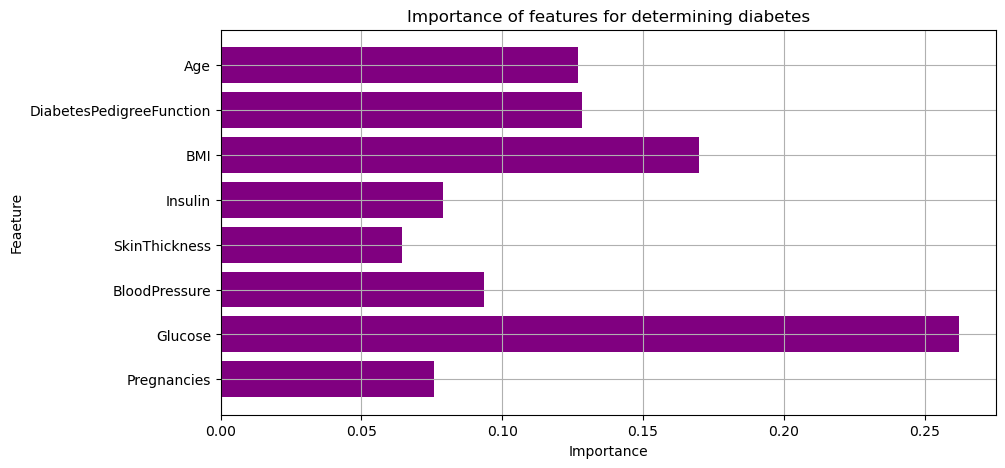

In [37]:
rf=RandomForestClassifier(n_estimators=49,random_state=1310)
rf.fit(X_train,y_train)
feat1=rf.feature_importances_
feat=X.columns
display(feat)
plt.figure(figsize=(10,5))
plt.grid(True)
plt.barh(feat,feat1,color='purple')
plt.xlabel('Importance')
plt.ylabel('Feaeture')
plt.title('Importance of features for determining diabetes')
plt.show()

# Самым важным для определения диабета оказался уровень глюкозы :)